# Calculate the Volume and Roundness of Acini
*Isobel Taylor-Hearn, 2023*
- This function loads a multi-channel image, extracts relevant channels (nuclear and membrane) to approximate the acinus structure, rescales it to ensure isotropic voxel spacing, applies thresholding and morphological operations to segment the acinus, and filters out unwanted structures based on size and shape constraints. 
- Acinar volume and roundness are recorded in a csv, along with any experimental parameters
- Sometimes proximal acini are identified as a single structure. The following steps are taken to ensure that proximal acini are split, without affecting acini that are truly non-round
    1. Test the roundness of the largest identified object. Identified objects with low roundness can arise from two proximal acini being identified as one
    2. If the identified object has low roundness, attempt to separate them using heavy erosion
        - This will separate acini with superficial attachments, without forcing separation on acini that are truly non-round
    3. Expand identified (separated) objects once labelled

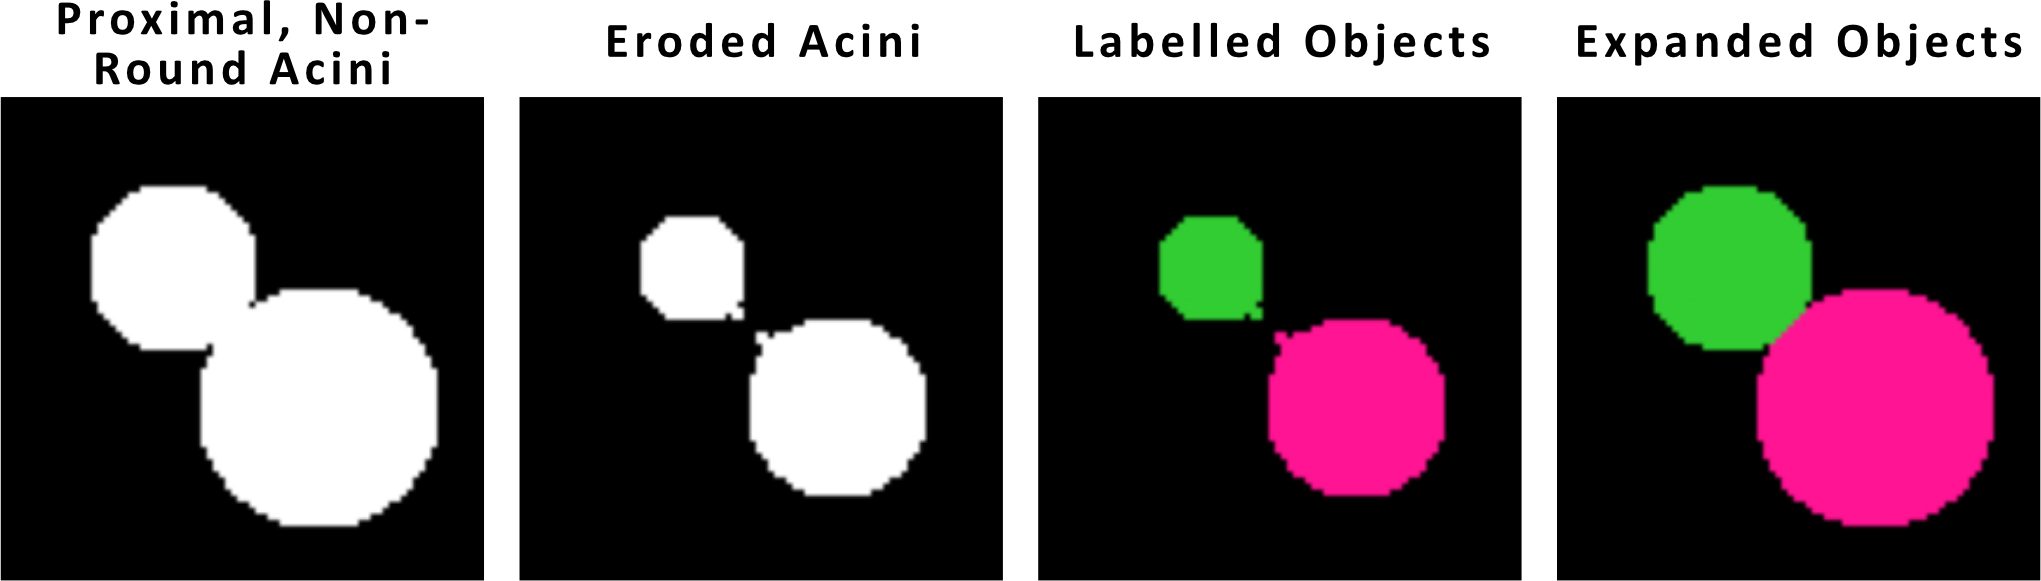

In [2]:
import numpy as np
import pandas as pd
import math
import os
import pathlib

from skimage import exposure, measure, util
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import expand_labels
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, ball, erosion
from skimage.transform import rescale

from scipy import ndimage as ndi

from tifffile import imread
import tifffile
from typing import Tuple, List

import matplotlib.pyplot as plt
from textwrap import wrap

import napari

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm

import tkinter as tk
from tkinter import filedialog

from PIL import ImageColor

# Set custom colour scheme for plots and visualistion
custom_colours = ["dodgerblue", "darkorange", "yellow", "limegreen", "red", "darkviolet", "deeppink" ]
custom_colours_napari = {
    0: np.array([0., 0., 0., 0.]) }
custom_colours_napari.update({
    i + 1: np.append(np.array(ImageColor.getcolor(base_color_hex, "RGB")) / 255.0, 1.0)  
    for i, base_color_hex in enumerate(custom_colours)
})

In [2]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Enables parallel jobs to run and display of a tqdm progress bar.

    Parameters:
    -----------
    tqdm_object : tqdm
        The tqdm progress bar instance to be updated.

    """
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def convert(img, target_type_min, target_type_max, target_type):
    """
    Converts an image to a specified data type while scaling its intensity values.

    This function rescales the intensity values of an image from its original range 
    to a new target range specified by `target_type_min` and `target_type_max`, and 
    then converts it to the desired data type.

    This step is required as deconvolved images are not always scaled 0->255! 

    Parameters:
    -----------
    img : numpy.ndarray
        The input image array to be converted.
    target_type_min : int or float
        The minimum value of the target intensity range.
    target_type_max : int or float
        The maximum value of the target intensity range.
    target_type : numpy.dtype
        The desired data type of the output image (e.g., np.uint8, np.float32).

    Returns:
    --------
    new_img : numpy.ndarray
        The rescaled image with values mapped to the new intensity range and converted 
        to the specified data type.

    Notes:
    ------
    - This function performs a linear transformation to scale pixel values.
    - It ensures that the output values are properly mapped between `target_type_min` and 
      `target_type_max`.
    """
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [4]:
def add_image_details(df, filename, flag):
    """
    Adds experimental details extracted from the filename to a dataframe.

    This function parses the filename to infer experimental details such as 
    well number, imaging day, mechanical stiffness condition, and treatment type.
    The extracted details are appended as new columns to the dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to which image metadata will be added.
    filename : str
        The filename of the image, used to extract experimental details.
    flag : str
        A flag indicating any segmentation issues detected during processing.

    Returns:
    --------
    df : pandas.DataFrame
        The updated dataframe with the following added columns:
        - 'filename': The original filename.
        - 'flag': Segmentation flag indicating potential issues.
        - 'well': The well number (1 or 2) inferred from the filename.
        - 'day': The experimental time point (0, 1, 3, or 7 days).
        - 'condition': The mechanical stiffness condition ('soft', 'stiff', or 'blank').
        - 'treatment': The treatment applied ('blebbistatin', 'ROCKi', 'batimastat', 'ABT737', or 'none').
        - 'image_type': A combined descriptor of the condition and day (e.g., 'soft, d3').
    """
    df["filename"] = filename
    df["flag"] = flag
    if ("well1" in filename):
        df["well"] = 1
    else:
        df["well"] = 2
    # Day #        
    if "d0" in filename:
        df["day"] =  0
    elif "d1" in filename:
        df["day"] =  1
    elif "d3" in filename:
        df["day"] =  3
    else:
        df["day"] =  7
    # Stiffness
    if 'soft' in filename:
        df["condition"] =  'soft'
    elif 'stiff' in filename:
        df["condition"] =  'stiff'
    else:
        df["condition"] =  'blank'
    if "bleb" in filename.lower():
        df["treatment"] = "blebbistatin"
    elif "rock" in filename.lower():
        df["treatment"] = "ROCKi"
    elif ("batimastat" in filename.lower()) or "mmpi" in filename.lower():
        df["treatment"] = "batimastat"
    elif "abt" in filename.lower():
        df["treatment"] = "ABT737"
    else:
        df["treatment"] = "none"
    df['image_type'] = df["condition"].astype(str) + ", d" + df["day"].astype(str)
    return df

In [5]:
def pixel_size(tif_path):
    """
    Extracts the pixel size (spacing) in microns from a TIFF image.

    This function reads TIFF metadata to determine the pixel spacing in the x, y, and z 
    dimensions, returning them as a list.

    Parameters:
    -----------
    tif_path : str
        Path to the TIFF file.

    Returns:
    --------
    original_spacing : list of float
        A list containing the pixel sizes in microns: [x_pixel_size_um, y_pixel_size_um, z_pixel_size_um].

    Notes:
    ------
    - The x and y resolutions are extracted from the TIFF XResolution and YResolution tags.
    - The z-spacing is inferred from the `IJMetadata` tag if available; otherwise, it falls back to 
      the `ImageDescription` tag.
    - Assumes the metadata is formatted in a way compatible with ImageJ or similar software.
    """
    with tifffile.TiffFile(tif_path) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            tif_tags[name] = value

        x_pixel_size_um = 1/((tif_tags["XResolution"])[0]/(tif_tags["XResolution"][1]))
        y_pixel_size_um = 1/((tif_tags["YResolution"])[0]/(tif_tags["YResolution"][1]))
        try:
            z_pixel_size_um = float(str(tif_tags["IJMetadata"]).split("nscales=")[1].split(",")[2].split("\\nunit")[0])
        except:
            z_pixel_size_um = (float(str(tif_tags["ImageDescription"]).split("spacing=")[1].split("loop")[0]))
       
    original_spacing = [x_pixel_size_um,y_pixel_size_um,z_pixel_size_um]
    return original_spacing

In [6]:
def segment_and_find_volume(path, nuclear_channel = 0, membrane_channel = 1, to_plot=False): 
    """
    Segments an acinus from a multi-channel 3D image and estimates its volume and roundness.

    This function loads a multi-channel image, extracts relevant channels (nuclear and membrane) 
    to approximate the acinus structure, rescales it to ensure isotropic voxel spacing, 
    applies thresholding and morphological operations to segment the acinus, and filters 
    out unwanted structures based on size and shape constraints. It also checks for segmentation 
    issues such as multiple acini, holes, or failure to detect a volume.

    1. Approximate the acinus as membrane + nuclear
    2. Alter the z spacing so x,y,z all have the same pixel size
    3. Rescale the image for faster processing
    4. Clip the image to reduce dynamic range
    5. Segment and only keep the largest identified acinus
    6. Test the roundness of the largest identified acinus: identified objects with low roundness can
        arise from two proximal acini being identified as one
    7. If the identified object has low roundness, attempt to separate them using heavy erosion
    8. Flag any issues with segmentation 
    9. Calculate acinar properties and record them along with experiemntal details

    Parameters:
    -----------
    path : str
        Path to the multi-channel image file.
    nuclear_channel : int, optional
        Index of the nuclear channel in the multi-channel image (default is 0).
    membrane_channel : int, optional
        Index of the membrane channel in the multi-channel image (default is 2).
    to_plot : bool, optional
        Whether to generate and display segmentation plots (default is False).
        Set to True to return images and segmentation for inspection and plotting.

    Returns:
    --------
    output : pandas.DataFrame
        A dataframe containing:
        - 'vol_um': Estimated acinus volume in cubic microns.
        - 'roundness': A measure of acinus roundness based on eigenvalues of the inertia tensor.
        - Experimental parameters extracted from the filename.

    Optional Returns (if `to_plot` is True):
    ----------------------------------------
    rescaled_acinus : numpy.ndarray
        The clipped and rescaled image used for segmentation.
    filtered_labelled_acinus : numpy.ndarray
        The final segmented and filtered labeled image.

    Notes:
    ------
    - The function applies Gaussian smoothing and Otsu thresholding for segmentation.
    - Small objects and holes are removed to refine segmentation.
    - If the detected acinus lacks sufficient roundness, an erosion step is applied to separate potential 
      neighboring acini.
    - If segmentation fails, a flag is set in the output dataframe to indicate the issue.
"""
    
    filename = os.path.basename(path).replace("_", "").lower()
    try:
        flag = "None"
        multi_channel_image = convert(imread(path), 0,255, np.uint8)
        acinus_approximation = (multi_channel_image[:,nuclear_channel,:,:] + multi_channel_image[:,membrane_channel,:,:]) 

        original_spacing = pixel_size(path) 
        scale_change = original_spacing[2] / original_spacing[0]
        new_pixel_size = 4 * original_spacing[0]

        rescaled_acinus = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = acinus_approximation, anti_aliasing= False) 
        clipped_acinus = rescaled_acinus.clip(min =np.quantile(rescaled_acinus, 0.1), max = np.quantile(rescaled_acinus, 0.85)) 
        acinus_smoothed = gaussian(clipped_acinus, sigma = 4)
        thresh = threshold_otsu(acinus_smoothed)
        binary_acinus = acinus_smoothed > thresh

        binary_acinus = remove_small_holes(binary_acinus, area_threshold = 100000)
        binary_acinus = remove_small_objects(binary_acinus, min_size = 10000)

        labelled_acinus = label(binary_acinus)
        table = regionprops_table(labelled_acinus, properties=('label', "area"),) 
        condition = (table['area'] >= (table["area"]).max())
        input_labels = table['label']
        output_labels = input_labels * condition
        filtered_labelled_acinus = util.map_array(labelled_acinus, input_labels, output_labels)

        table = regionprops_table(filtered_labelled_acinus, properties=('label', 'inertia_tensor_eigvals'),) 
        condition = table['inertia_tensor_eigvals-2']/table['inertia_tensor_eigvals-0'] >= (0.55)

    #######SEPARATE PROXIMAL ACINI IF NECESSARY########################################################################
        if condition == False:
            flag = "multiple_acini_split"
            acinus_smoothed = gaussian(clipped_acinus, sigma = 1)
            thresh = threshold_otsu(acinus_smoothed)
            binary_acinus = acinus_smoothed > thresh
            binary_acinus = remove_small_holes(binary_acinus, area_threshold = 100000)
            binary_acinus = remove_small_objects(binary_acinus, min_size = 10000)
            binary_acinus = erosion(binary_acinus, ball(8))
            labelled_acinus = label(binary_acinus)
            table = regionprops_table(labelled_acinus, properties=('label', "area"),)
            condition = (table['area'] >= (table["area"]).max())
            input_labels = table['label']
            output_labels = input_labels * condition
            filtered_labelled_acinus = util.map_array(labelled_acinus, input_labels, output_labels)
            filtered_labelled_acinus = expand_labels(filtered_labelled_acinus, distance=8)   
    ###################################################################################################################
        hole_sizes =  [region.area for region in regionprops(label(util.invert(binary_acinus)))]
        if len(hole_sizes)> 1:
            flag = "Hole"
        areas = [(region.area) for region in regionprops(labelled_acinus)]
        if len(areas) == 0:
            flag = "No Area"
        vol_in_um = [(region.area)*(new_pixel_size**3) for region in regionprops(filtered_labelled_acinus)]
        output = pd.DataFrame(columns=['vol_um'])
        output["vol_um"] = vol_in_um
        output["roundness"] =  [(region.inertia_tensor_eigvals[2]/region.inertia_tensor_eigvals[0]) for region in regionprops(filtered_labelled_acinus)]
        output = add_image_details(output, filename, flag) 
        
    #######PLOT OUTPUTS IF NECESSARY###################################################################################
        if to_plot == True:
            slice_to_display = int(rescaled_acinus.shape[0]/2)
            print(flag)
            gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1,1,1])
            fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(8,4), gridspec_kw = gridspec)
            ax[0].imshow(20*rescaled_acinus[slice_to_display,:,:] , cmap = "gray")
            ax[1].imshow(acinus_smoothed[slice_to_display,:,:], cmap="gray")
            ax[2].imshow(filtered_labelled_acinus[slice_to_display,:,:], cmap = "gray")
            cols = ["Original", "Clipped",  "Identified Objects"]
            for i in range(3):
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i].set_title(cols[i]) 
            plt.savefig("Segmented_{}.png".format(str(path).split("\\")[-1]), bbox_inches="tight", transparent="True")
            return output, rescaled_acinus, filtered_labelled_acinus
        else:
            return output
    except:
        return pd.DataFrame()

# Single Run
- Test whether identified labels give good agreement with the input image
- This code returns the output (details about the acinus), along with the clipped + rescaled image used for segmentation and the calculated acinar label
    - The latter two of these can be used for 3d visualisation in napari
- A diagram of the various steps is also produced to enable troubleshooting
- **Note**: interactive elements sometimes display behind the notebook! Minimise e.g. VSCode to see if the dialogue box is hidden!

None


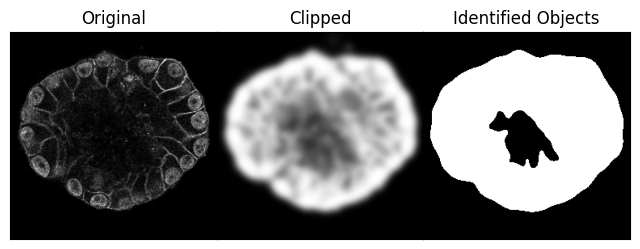

In [7]:
root = tk.Tk()
root.withdraw()
root.update()
input_folder = filedialog.askdirectory(title="Where are the images that you want to process saved?")
file_extension = input("What image type to do you want to analyse (e.g. tif, tiff, r3d etc)")
image_paths = list(pathlib.Path(input_folder).rglob("*.{}".format(file_extension)))
output, rescaled_acinus, filtered_labelled_image = segment_and_find_volume(image_paths[0], to_plot=True)

In [8]:
output

,vol_um,roundness,filename,flag,well,day,condition,treatment,image_type
0,164260.61628,0.712014,10amitocaaxpdrp1soft0041.75xzoomseries0010cmle...,None,2,7,soft,none,"soft, d7"


In [ ]:
viewer = napari.Viewer()
viewer.add_image(rescaled_acinus)
viewer.add_labels(filtered_labelled_image, colormap=custom_colours_napari)


c:\Users\itayl\anaconda3\envs\napari-env\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<Labels layer 'filtered_labelled_image' at 0x228a646af50>

# Full Run
- Ask user for input and output folder
    - input_folder: where to look for images to segment
    - output_folder: where to save the output .csv file
- An output .csv is made, concatenating the quantifications of each image in the input folder

Things to bear in mind:
1. Tasks run in parallel. If you have a lower processing power, make n_jobs (which is the number of images quantified at the same time) smaller. If you have a lot of processing power, increase n_jobs to increase speed
2. Make sure you type your file extension carefully! Caps matter!

In [17]:
root = tk.Tk()
root.withdraw()
root.update()
input_folder = filedialog.askdirectory(title="Where are the images that you want to process saved?")
output_folder = filedialog.askdirectory(title="Where do you want to save the output .csv (Excel) file?")

file_extension = input("What image type to do you want to analyse (e.g. tif, tiff, r3d etc)")
output_filename = input("What do you want the output file to be called (NO SPACES!). You don't need to include a file extension")

image_paths = list(pathlib.Path(input_folder).rglob("*.{}".format(file_extension)))
if image_paths:
    print("{} file(s) found".format(len(image_paths)))
    with tqdm_joblib(tqdm(desc="Image Analysis", total=len(image_paths))) as progress_bar:
        total = pd.concat(Parallel(n_jobs=3)(delayed(segment_and_find_volume)(path) for path in image_paths)).reset_index()
    total.to_csv(output_folder+"\\{}.csv".format(output_filename))
    print("Output saved in {}/{}.csv".format(output_folder, output_filename))
else:
    print("No files found in {}. \\Check your file type: check if your files are .tif, .tiff, .r3d".format(input_folder))

C:/Users/itayl/The University of Manchester Dropbox/Isobel Taylor-Hearn/Bel
1 file(s) found


Image Analysis: 100%|██████████| 1/1 [01:06<00:00, 66.15s/it]


Output saved in C:/Users/itayl/The University of Manchester Dropbox/Isobel Taylor-Hearn/Bel/test_output.csv
